In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
# import pytorch_lightning as pl
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import seaborn as sns
import folium
from folium.plugins import HeatMap
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split




In [2]:
data_train = pd.read_csv('./data/data_train_complete.csv')
not_norm_features = ["grupo", "btsId", "btsNetNome", "RssiId", "indoor", "rssi_id"]

data_train

,grupo,btsId,btsNetNome,lat_x,lon_x,cch,azimuth,RssiId,ponto_id,delay_1,delay_2,delay_3,lat_y,lon_y,indoor,rssi_id,rssi_value
0,1,BTS_1_1,PEMDL01_1,-8.04342,-34.9520,873,0,rssi_1_1,6604,5.0,3.0,2.0,-8.055786,-34.951505,True,rssi_1_1,-103.705000
1,1,BTS_1_1,PEMDL01_1,-8.04342,-34.9520,873,0,rssi_1_1,5515,5.0,3.0,2.0,-8.055784,-34.951608,True,rssi_1_1,-105.225000
2,1,BTS_1_1,PEMDL01_1,-8.04342,-34.9520,873,0,rssi_1_1,5049,5.0,3.0,2.0,-8.055506,-34.951693,True,rssi_1_1,-102.610000
3,1,BTS_1_1,PEMDL01_1,-8.04342,-34.9520,873,0,rssi_1_1,8737,4.0,7.0,2.0,-8.050390,-34.959630,False,rssi_1_1,-89.140000
4,1,BTS_1_1,PEMDL01_1,-8.04342,-34.9520,873,0,rssi_1_1,1203,5.0,3.0,2.0,-8.055380,-34.951736,True,rssi_1_1,-109.088333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60380,3,BTS_3_3,PEMDL09_3,-8.05532,-34.9579,869,240,rssi_3_3,5734,5.0,3.0,2.0,-8.055784,-34.951608,True,rssi_3_3,-108.120000
60381,3,BTS_3_3,PEMDL09_3,-8.05532,-34.9579,869,240,rssi_3_3,5191,5.0,3.0,2.0,-8.055784,-34.951608,True,rssi_3_3,-108.120000
60382,3,BTS_3_3,PEMDL09_3,-8.05532,-34.9579,869,240,rssi_3_3,5390,5.0,3.0,2.0,-8.055784,-34.951608,True,rssi_3_3,-108.120000
60383,3,BTS_3_3,PEMDL09_3,-8.05532,-34.9579,869,240,rssi_3_3,860,5.0,3.0,2.0,-8.055380,-34.951736,True,rssi_3_3,-115.000000


In [3]:
# Identify features to normalize
features_to_normalize = [col for col in data_train.columns if col not in not_norm_features]

# Initialize the scaler and fit-transform the numeric features
scaler = MinMaxScaler()
data_train[features_to_normalize] = scaler.fit_transform(data_train[features_to_normalize])
print(features_to_normalize)

# Handle categorical (text) data using OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
encoded_categorical_data = encoder.fit_transform(data_train[not_norm_features])

# Create a DataFrame from the encoded categorical data
encoded_feature_names = encoder.get_feature_names_out(not_norm_features)
encoded_df = pd.DataFrame(encoded_categorical_data, index=data_train.index, columns=encoded_feature_names)

# Combine the normalized numeric data and the encoded categorical data
data_train_combined = pd.concat([data_train[features_to_normalize], encoded_df], axis=1)

# Convert the combined DataFrame to a PyTorch tensor
data_tensor = torch.tensor(data_train_combined.values, dtype=torch.float32)

# Create TensorDataset and DataLoader
dataset = TensorDataset(data_tensor)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

data_loader


['lat_x', 'lon_x', 'cch', 'azimuth', 'ponto_id', 'delay_1', 'delay_2', 'delay_3', 'lat_y', 'lon_y', 'rssi_value']


In [4]:
data_train_combined

,lat_x,lon_x,cch,azimuth,ponto_id,delay_1,delay_2,delay_3,lat_y,lon_y,...,indoor_True,rssi_id_rssi_1_1,rssi_id_rssi_1_2,rssi_id_rssi_1_3,rssi_id_rssi_2_1,rssi_id_rssi_2_2,rssi_id_rssi_2_3,rssi_id_rssi_3_1,rssi_id_rssi_3_2,rssi_id_rssi_3_3
0,1.0,0.446024,0.50,0.0,0.682481,0.571429,0.428571,0.285714,0.286672,0.566147,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.446024,0.50,0.0,0.569922,0.571429,0.428571,0.285714,0.286824,0.559159,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.446024,0.50,0.0,0.521757,0.571429,0.428571,0.285714,0.307997,0.553392,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.446024,0.50,0.0,0.902946,0.428571,1.000000,0.285714,0.697639,0.014925,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.446024,0.50,0.0,0.124238,0.571429,0.428571,0.285714,0.317593,0.550475,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60380,0.0,0.000000,0.25,1.0,0.592558,0.571429,0.428571,0.285714,0.286824,0.559159,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
60381,0.0,0.000000,0.25,1.0,0.536434,0.571429,0.428571,0.285714,0.286824,0.559159,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
60382,0.0,0.000000,0.25,1.0,0.557003,0.571429,0.428571,0.285714,0.286824,0.559159,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
60383,0.0,0.000000,0.25,1.0,0.088786,0.571429,0.428571,0.285714,0.317593,0.550475,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [5]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

input_dim = 100
output_dim = data_train_combined.shape[1]

In [6]:
generator = Generator(input_dim, output_dim)
discriminator = Discriminator(output_dim)

lr = 0.0002
b1 = 0.5
b2 = 0.999

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))
adversarial_loss = nn.BCELoss()

In [7]:
generator_losses = []
discriminator_losses = []

def train_gan(data_loader, epochs=100):
    for epoch in range(epochs):
        for real_data in data_loader:
            real_data = real_data[0]
            batch_size = real_data.size(0)

            real_labels = torch.ones(batch_size, 1)
            fake_labels = torch.zeros(batch_size, 1)

            optimizer_D.zero_grad()
            outputs = discriminator(real_data)
            d_loss_real = adversarial_loss(outputs, real_labels)

            noise = torch.randn(batch_size, input_dim)
            fake_data = generator(noise)
            outputs = discriminator(fake_data.detach())
            d_loss_fake = adversarial_loss(outputs, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_D.step()

            optimizer_G.zero_grad()
            outputs = discriminator(fake_data)
            g_loss = adversarial_loss(outputs, real_labels)
            g_loss.backward()
            optimizer_G.step()

        generator_losses.append(d_loss.item())
        discriminator_losses.append(g_loss.item())

        print(f"Epoch {epoch+1}/{epochs}, Loss D: {d_loss.item()}, Loss G: {g_loss.item()}")

train_gan(data_loader, epochs=100)

Epoch 1/100, Loss D: 0.6154128909111023, Loss G: 1.9577442407608032
Epoch 2/100, Loss D: 0.15313838422298431, Loss G: 2.7957680225372314
Epoch 3/100, Loss D: 0.5861186981201172, Loss G: 1.7211816310882568
Epoch 4/100, Loss D: 0.3711642920970917, Loss G: 2.7748963832855225
Epoch 5/100, Loss D: 0.5206995010375977, Loss G: 2.204282283782959
Epoch 6/100, Loss D: 0.452791690826416, Loss G: 2.4080400466918945
Epoch 7/100, Loss D: 0.36038902401924133, Loss G: 2.4861159324645996
Epoch 8/100, Loss D: 0.4957732856273651, Loss G: 2.335421323776245
Epoch 9/100, Loss D: 0.23676055669784546, Loss G: 3.2163078784942627
Epoch 10/100, Loss D: 0.38114240765571594, Loss G: 2.35223388671875
Epoch 11/100, Loss D: 0.3492070436477661, Loss G: 2.8547914028167725
Epoch 12/100, Loss D: 0.3895702362060547, Loss G: 1.943162202835083
Epoch 13/100, Loss D: 0.37825286388397217, Loss G: 3.0891916751861572
Epoch 14/100, Loss D: 0.20724794268608093, Loss G: 3.4637985229492188
Epoch 15/100, Loss D: 0.31319043040275574, 

In [8]:
# Define the function to generate new data
def generate_new_data(generator, num_samples, input_dim):
    noise = torch.randn(num_samples, input_dim)
    generated_data = generator(noise)

    return generated_data

# Generate new data
num_samples = 10000
generated_data = generate_new_data(generator, num_samples, input_dim).detach().numpy()

num_numeric_features = len(features_to_normalize)
numeric_data_generated = generated_data[:, :num_numeric_features]

new_data_numeric_not_norm = scaler.inverse_transform(numeric_data_generated)
new_data_numeric_not_norm

array([[  -8.043426,  -34.952118,  875.0533  , ...,   -8.052289,
         -34.947186,  -89.9337  ],
       [  -8.043435,  -34.952045,  873.0275  , ...,   -8.055737,
         -34.95157 , -104.40289 ],
       [  -8.043442,  -34.95203 ,  874.9741  , ...,   -8.055578,
         -34.951653, -108.21778 ],
       ...,
       [  -8.043421,  -34.951923,  873.1347  , ...,   -8.051263,
         -34.95963 ,  -81.60836 ],
       [  -8.043438,  -34.952015,  874.99036 , ...,   -8.055387,
         -34.951767, -106.82093 ],
       [  -8.043438,  -34.95215 ,  874.94116 , ...,   -8.055062,
         -34.94972 ,  -96.03539 ]], dtype=float32)

In [9]:
categorical_data_generated = generated_data[:, num_numeric_features:]
categorical_data_not_norm = encoder.inverse_transform(categorical_data_generated)
categorical_data_not_norm

array([[1, 'BTS_1_3', 'PEMDL01_3', 'rssi_1_3', False, 'rssi_1_3'],
       [1, 'BTS_1_1', 'PEMDL01_1', 'rssi_1_1', True, 'rssi_1_1'],
       [1, 'BTS_1_3', 'PEMDL01_3', 'rssi_1_3', True, 'rssi_1_3'],
       ...,
       [1, 'BTS_1_1', 'PEMDL01_1', 'rssi_1_1', False, 'rssi_1_1'],
       [1, 'BTS_1_3', 'PEMDL01_3', 'rssi_1_3', True, 'rssi_1_3'],
       [1, 'BTS_1_3', 'PEMDL01_3', 'rssi_1_3', False, 'rssi_1_3']],
      dtype=object)

In [10]:
combined_new_data = np.hstack((new_data_numeric_not_norm, categorical_data_not_norm))

# Create column names for the combined data
numeric_feature_names = features_to_normalize
categorical_feature_names = encoder.get_feature_names_out(not_norm_features)
combined_feature_names = np.concatenate((numeric_feature_names, not_norm_features))


In [21]:
new_data_df = pd.DataFrame(combined_new_data, columns=combined_feature_names)
new_data_df

,lat_x,lon_x,cch,azimuth,ponto_id,delay_1,delay_2,delay_3,lat_y,lon_y,rssi_value,grupo,btsId,btsNetNome,RssiId,indoor,rssi_id
0,-8.043426,-34.952118,875.053284,238.051697,7915.430176,4.416348,0.893991,4.578083,-8.052289,-34.947186,-89.933701,1,BTS_1_3,PEMDL01_3,rssi_1_3,False,rssi_1_3
1,-8.043435,-34.952045,873.027527,0.842068,6036.39209,5.018973,2.99024,2.026521,-8.055737,-34.951569,-104.402893,1,BTS_1_1,PEMDL01_1,rssi_1_1,True,rssi_1_1
2,-8.043442,-34.95203,874.974121,239.050156,3152.32666,5.010802,2.990133,2.139574,-8.055578,-34.951653,-108.217781,1,BTS_1_3,PEMDL01_3,rssi_1_3,True,rssi_1_3
3,-8.043427,-34.951996,872.995361,-0.140928,3617.915527,4.982809,2.986862,1.990379,-8.05556,-34.95158,-106.172554,1,BTS_1_1,PEMDL01_1,rssi_1_1,True,rssi_1_1
4,-8.043438,-34.952019,874.961914,239.153015,1864.103027,5.040684,2.97449,2.915256,-8.055464,-34.95142,-98.218964,1,BTS_1_3,PEMDL01_3,rssi_1_3,True,rssi_1_3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-8.043426,-34.952011,872.978699,-0.887677,2788.961426,5.024264,2.957125,3.158183,-8.055801,-34.951279,-115.648071,1,BTS_1_1,PEMDL01_1,rssi_1_1,True,rssi_1_1
9996,-8.043427,-34.95203,872.941284,0.194669,1357.208984,5.024556,2.967142,2.329482,-8.055583,-34.951611,-115.062653,1,BTS_1_1,PEMDL01_1,rssi_1_1,True,rssi_1_1
9997,-8.043421,-34.951923,873.134705,-2.469932,8003.547363,4.505034,6.462189,1.011368,-8.051263,-34.959629,-81.60836,1,BTS_1_1,PEMDL01_1,rssi_1_1,False,rssi_1_1
9998,-8.043438,-34.952015,874.990356,239.323349,1237.869263,5.047856,2.96791,2.017198,-8.055387,-34.951767,-106.82093,1,BTS_1_3,PEMDL01_3,rssi_1_3,True,rssi_1_3


In [22]:
old_data = pd.read_csv("./data/data_train_complete.csv")
new_data = new_data_df.copy()
# expanded_data = pd.concat((old_data, new_data))
expanded_data = new_data.copy()

features = ["rssi_value", "delay_1", "delay_2", "delay_3", "lon_y", "lat_y"]

expanded_data = expanded_data[features]

expanded_data

,rssi_value,delay_1,delay_2,delay_3,lon_y,lat_y
0,-89.933701,4.416348,0.893991,4.578083,-34.947186,-8.052289
1,-104.402893,5.018973,2.99024,2.026521,-34.951569,-8.055737
2,-108.217781,5.010802,2.990133,2.139574,-34.951653,-8.055578
3,-106.172554,4.982809,2.986862,1.990379,-34.95158,-8.05556
4,-98.218964,5.040684,2.97449,2.915256,-34.95142,-8.055464
...,...,...,...,...,...,...
9995,-115.648071,5.024264,2.957125,3.158183,-34.951279,-8.055801
9996,-115.062653,5.024556,2.967142,2.329482,-34.951611,-8.055583
9997,-81.60836,4.505034,6.462189,1.011368,-34.959629,-8.051263
9998,-106.82093,5.047856,2.96791,2.017198,-34.951767,-8.055387


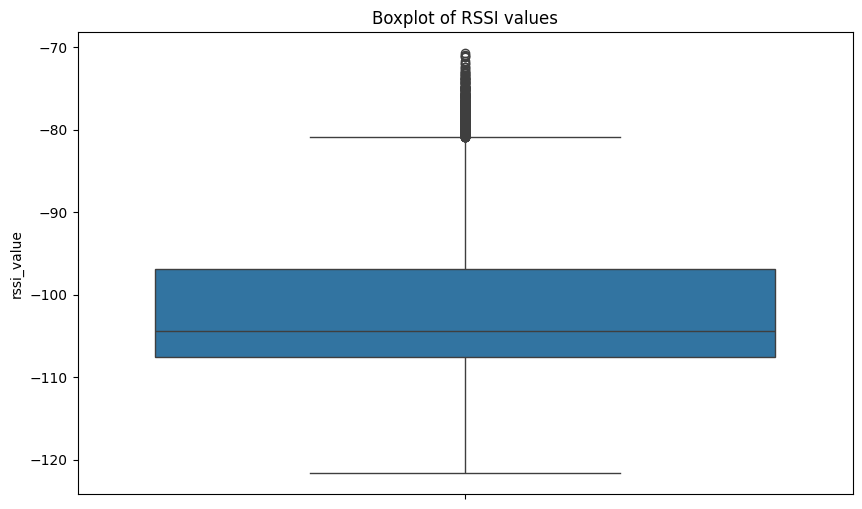

In [23]:

### boxplot of rssi values
plt.figure(figsize=(10, 6))
sns.boxplot(expanded_data["rssi_value"])
plt.title("Boxplot of RSSI values")
plt.show()

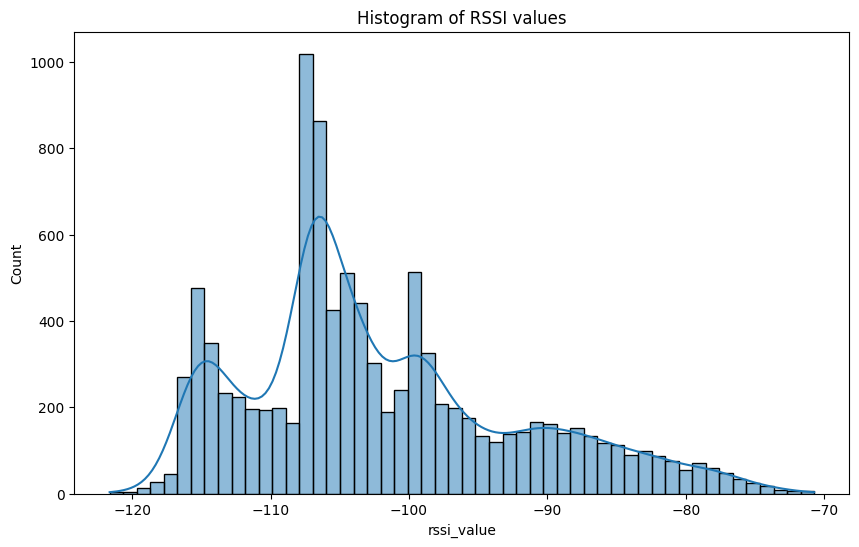

In [24]:
### histogram of rssi values
plt.figure(figsize=(10, 6))
sns.histplot(expanded_data["rssi_value"], kde=True)
plt.title("Histogram of RSSI values")
plt.show()

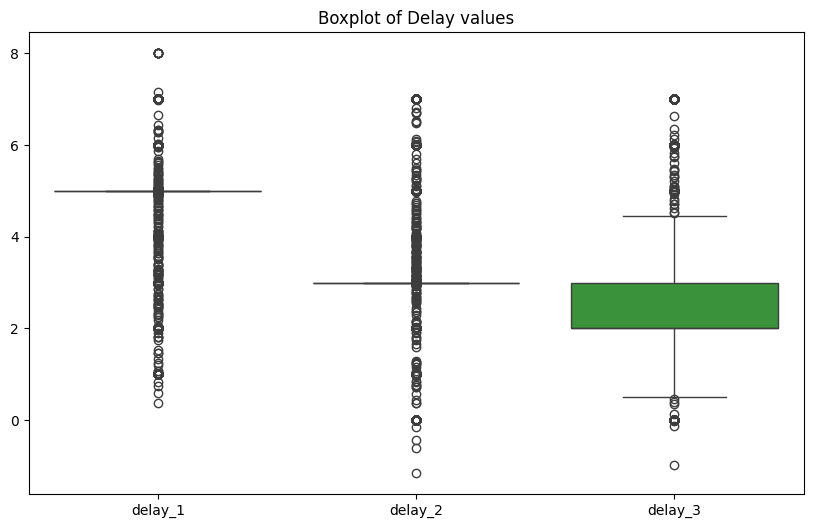

In [17]:
### boxplot of all delay values
plt.figure(figsize=(10, 6))
sns.boxplot(data=expanded_data[["delay_1", "delay_2", "delay_3"]])
plt.title("Boxplot of Delay values")
plt.show()

In [15]:
### make a map of the BTS
map = folium.Map(location=[-8.5489, -32.6388], zoom_start=12)

# Add a heatmap of the BTS
heatmap_data = expanded_data[["lat_y", "lon_y"]].values
HeatMap(heatmap_data).add_to(map)

map

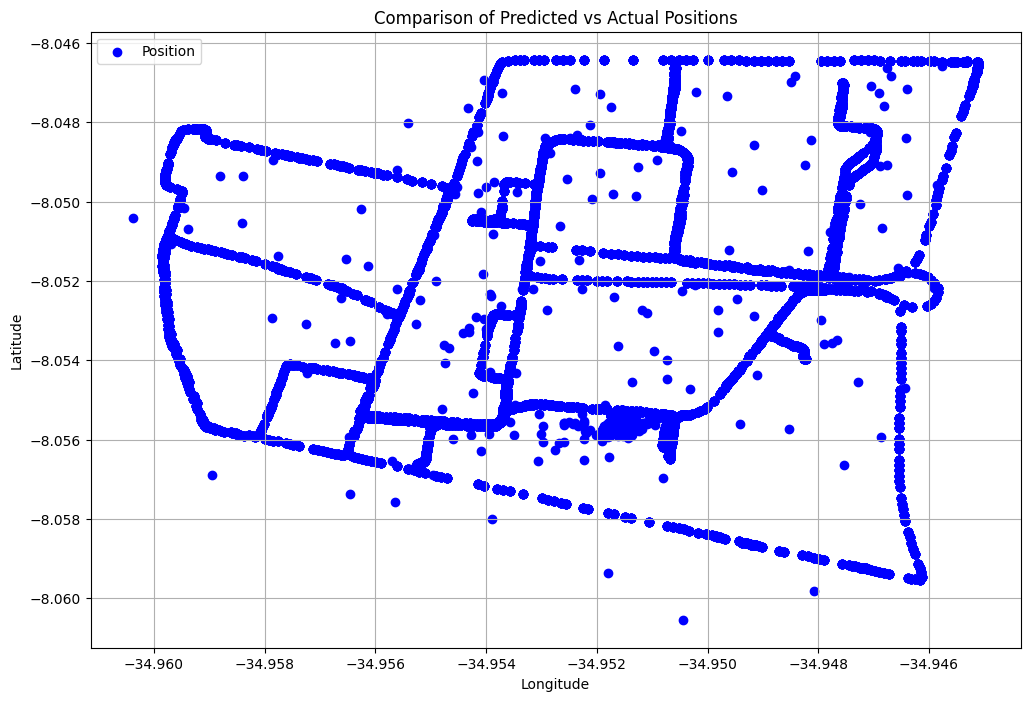

In [19]:
true_lat = expanded_data['lat_y'].values
true_lon = expanded_data['lon_y'].values

# pred_lat = predicted_location[:, 1]
# pred_lon = predicted_location[:, 0]

plt.figure(figsize=(12, 8))
plt.scatter(true_lon, true_lat, color='blue', label='Position')
# plt.scatter(pred_lon, pred_lat, color='blue', label='Position')

# for i in range(len(true_lat)):
    # plt.plot([true_lon[i]], [true_lat[i]], 'gray', linestyle='--')

plt.title('Comparison of Predicted vs Actual Positions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
### knn
# features to normalize
features = ["rssi_value", "delay_1", "delay_2", "delay_3"]

# Initialize the scaler and fit-transform the numeric features
scaler = MinMaxScaler()
expanded_data[features] = scaler.fit_transform(expanded_data[features])

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X = expanded_data[features]
y = expanded_data[["lat_y", "lon_y"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a KNN model
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

# Make predictions
predicted_location = knn.predict(X_test)
predicted_location

array([[-8.05545597076416, -34.95184860229492],
       [-8.055560684204101, -34.95163116455078],
       [-8.048581314086913, -34.947120666503906],
       ...,
       [-8.052585220336914, -34.95487670898437],
       [-8.055758857727051, -34.95136032104492],
       [-8.055053520202637, -34.95743408203125]], dtype=object)

In [26]:
# Calculando os erros em metros
errors_in_meters = []
for real, pred in zip(y_test.values, predicted_location):
    real_coords = (real[1], real[0])  # (lat, lon)
    pred_coords = (pred[1], pred[0])  # (lat, lon)
    error_distance = geodesic(real_coords, pred_coords).meters
    errors_in_meters.append(error_distance)

# Convertendo para numpy array para facilitar o manuseio
errors_in_meters = np.array(errors_in_meters)

mean_error = errors_in_meters.mean()
std_error = errors_in_meters.std()
max_error = errors_in_meters.max()
min_error = errors_in_meters.min()
med_error = np.median(errors_in_meters)

print(f'Mean Error: {mean_error:.2f} meters')
print(f'Std Error: {std_error:.2f} meters')
print(f'Max Error: {max_error:.2f} meters')
print(f'Min Error: {min_error:.2f} meters')
print(f'Median Error: {med_error:.2f} meters')

Mean Error: 12.52 meters
Std Error: 21.36 meters
Max Error: 291.36 meters
Min Error: 0.02 meters
Median Error: 4.20 meters


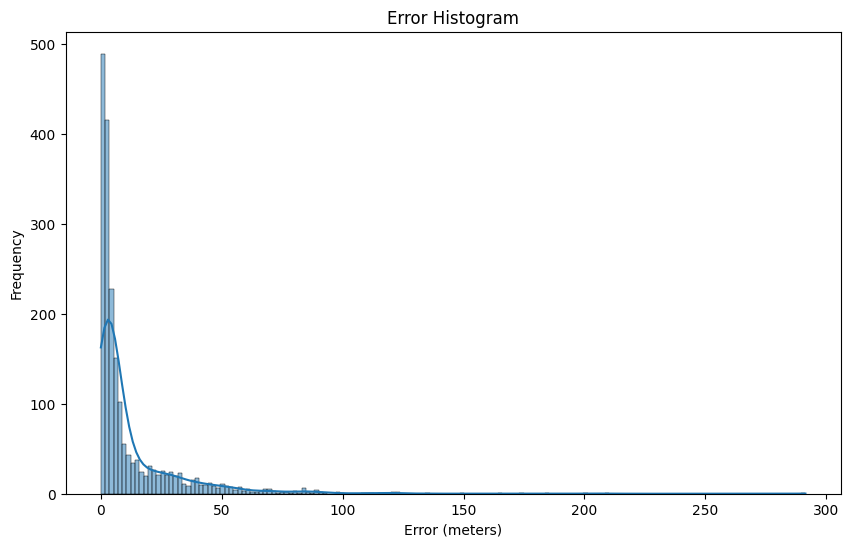

In [27]:
## error histogram plot
plt.figure(figsize=(10, 6))
sns.histplot(errors_in_meters, kde=True)
plt.title('Error Histogram')
plt.xlabel('Error (meters)')
plt.ylabel('Frequency')
plt.show()

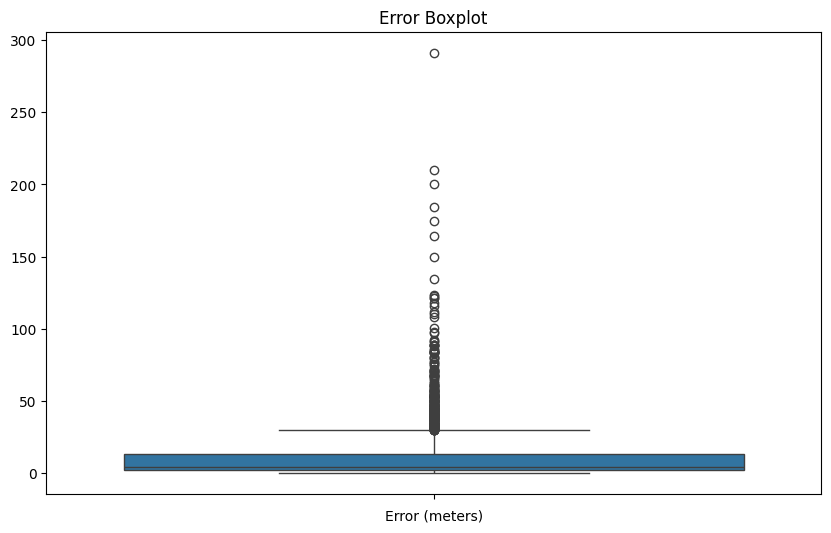

In [28]:
### error boxplot plot
plt.figure(figsize=(10, 6))
sns.boxplot(errors_in_meters)
plt.title('Error Boxplot')
plt.xlabel('Error (meters)')
plt.show()

In [24]:
predicted_location[:, 1]

array([-34.94881, -34.95134040000001, -34.951879999999996, ...,
       -34.951328000000004, -34.955618, -34.951331], dtype=object)

True Latitude: [-8.055623054504395 -8.055588722229004 -8.048447608947754 ...
 -8.052831649780273 -8.055743217468262 -8.054697036743164]
True Longitude: [-34.951995849609375 -34.951690673828125 -34.947296142578125 ...
 -34.95523452758789 -34.95133590698242 -34.95786666870117]
Predicted Latitude (correto): [-8.05545597076416 -8.055560684204101 -8.048581314086913 ...
 -8.052585220336914 -8.055758857727051 -8.055053520202637]
Predicted Longitude (correto): [-34.95184860229492 -34.95163116455078 -34.947120666503906 ...
 -34.95487670898437 -34.95136032104492 -34.95743408203125]


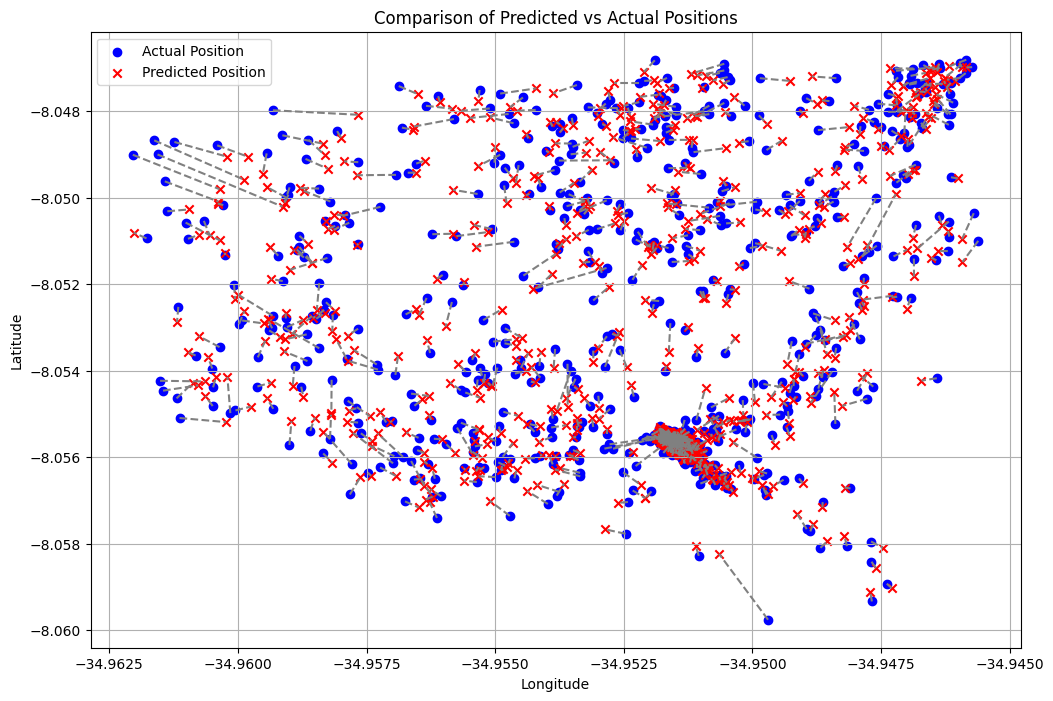

In [29]:
true_lat = y_test['lat_y'].values
true_lon = y_test['lon_y'].values
pred_lat = predicted_location[:, 0]
pred_lon = predicted_location[:, 1]

# Verificar os dados de entrada
print("True Latitude:", true_lat)
print("True Longitude:", true_lon)
print("Predicted Latitude (correto):", pred_lat)
print("Predicted Longitude (correto):", pred_lon)

# Plotar os dados corrigidos
plt.figure(figsize=(12, 8))
plt.scatter(true_lon, true_lat, color='blue', label='Actual Position')
plt.scatter(pred_lon, pred_lat, color='red', marker='x', label='Predicted Position')

for i in range(len(true_lat)):
    plt.plot([true_lon[i], pred_lon[i]], [true_lat[i], pred_lat[i]], 'gray', linestyle='--')

plt.title('Comparison of Predicted vs Actual Positions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()


In [64]:
# Generate new data
num_samples = 10000
generated_data = generate_new_data(generator, num_samples, input_dim).detach().numpy()

not_norm_features = ["grupo", "btsId", "btsNetNome", "RssiId", "indoor", "rssi_id"]
features_to_normalize = [col for col in data_train.columns if col not in not_norm_features]
print(features_to_normalize)

num_numeric_features = len(features_to_normalize)
print(num_numeric_features)
numeric_data_generated = generated_data[:, :num_numeric_features]
print(numeric_data_generated)

new_data_numeric_not_norm = scaler.inverse_transform(numeric_data_generated)
# new_data_numeric_not_norm = scaler.inverse_transform(numeric_data_generated.reshape(-1, 4))

print(new_data_numeric_not_norm.shape)
new_data_numeric_not_norm

['lat_x', 'lon_x', 'cch', 'azimuth', 'ponto_id', 'delay_1', 'delay_2', 'delay_3', 'lat_y', 'lon_y', 'rssi_value']
11
[[0.9999701  0.43924505 0.627244   ... 0.82786345 0.6848058  0.4817998 ]
 [0.99999607 0.45265472 0.63207644 ... 0.30793756 0.60345805 0.00265563]
 [0.9999933  0.44454166 0.6248457  ... 0.30383658 0.5714719  0.10931386]
 ...
 [0.999993   0.44306484 0.62351847 ... 0.3207614  0.55920553 0.17081629]
 [0.9999929  0.44272253 0.6226121  ... 0.30538362 0.5625883  0.17523746]
 [0.9999958  0.4454797  0.62572074 ... 0.28688344 0.56678283 0.19643721]]
(10000, 11)


array([[0.9999701 , 0.43924505, 0.627244  , ..., 0.82786345, 0.6848058 ,
        0.4817998 ],
       [0.99999607, 0.45265472, 0.63207644, ..., 0.30793756, 0.60345805,
        0.00265563],
       [0.9999933 , 0.44454166, 0.6248457 , ..., 0.30383658, 0.5714719 ,
        0.10931386],
       ...,
       [0.999993  , 0.44306484, 0.62351847, ..., 0.3207614 , 0.55920553,
        0.17081629],
       [0.9999929 , 0.44272253, 0.6226121 , ..., 0.30538362, 0.5625883 ,
        0.17523746],
       [0.9999958 , 0.4454797 , 0.62572074, ..., 0.28688344, 0.56678283,
        0.19643721]], dtype=float32)

In [61]:
categorical_data_generated = generated_data[:, num_numeric_features:]
categorical_data_not_norm = encoder.inverse_transform(categorical_data_generated)

categorical_data_not_norm

array([[1, 'BTS_1_3', 'PEMDL01_3', 'rssi_1_3', True, 'rssi_1_3'],
       [1, 'BTS_1_3', 'PEMDL01_3', 'rssi_1_3', True, 'rssi_1_3'],
       [1, 'BTS_1_3', 'PEMDL01_3', 'rssi_1_3', True, 'rssi_1_3'],
       ...,
       [1, 'BTS_1_3', 'PEMDL01_3', 'rssi_1_3', True, 'rssi_1_3'],
       [1, 'BTS_1_3', 'PEMDL01_3', 'rssi_1_3', True, 'rssi_1_3'],
       [1, 'BTS_1_3', 'PEMDL01_3', 'rssi_1_3', True, 'rssi_1_3']],
      dtype=object)

In [65]:
# Combine the arrays
combined_new_data = np.hstack((new_data_numeric_not_norm, categorical_data_not_norm))


In [66]:
new_data_df = pd.DataFrame(combined_new_data, columns=combined_feature_names)
new_data_df

,lat_x,lon_x,cch,azimuth,ponto_id,delay_1,delay_2,delay_3,lat_y,lon_y,rssi_value,grupo,btsId,btsNetNome,RssiId,indoor,rssi_id
0,0.99997,0.439245,0.627244,0.999545,0.938822,0.208785,0.377751,0.622529,0.827863,0.684806,0.4818,1,BTS_1_3,PEMDL01_3,rssi_1_3,True,rssi_1_3
1,0.999996,0.452655,0.632076,0.999593,0.253075,0.560224,0.423121,0.467069,0.307938,0.603458,0.002656,1,BTS_1_3,PEMDL01_3,rssi_1_3,True,rssi_1_3
2,0.999993,0.444542,0.624846,0.99938,0.340697,0.570372,0.427849,0.355308,0.303837,0.571472,0.109314,1,BTS_1_3,PEMDL01_3,rssi_1_3,True,rssi_1_3
3,0.999994,0.444206,0.624401,0.999377,0.492718,0.574285,0.430295,0.283008,0.301788,0.564662,0.19484,1,BTS_1_3,PEMDL01_3,rssi_1_3,False,rssi_1_3
4,0.999994,0.446576,0.624857,0.999478,0.226019,0.574834,0.42401,0.418002,0.300571,0.577414,0.350466,1,BTS_1_3,PEMDL01_3,rssi_1_3,False,rssi_1_3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.999995,0.445389,0.622747,0.999395,0.465119,0.570774,0.426167,0.275908,0.31024,0.557029,0.390679,1,BTS_1_3,PEMDL01_3,rssi_1_3,False,rssi_1_3
9996,0.999997,0.447223,0.627598,0.999521,0.645136,0.57425,0.424633,0.277688,0.280084,0.567712,0.184565,1,BTS_1_3,PEMDL01_3,rssi_1_3,False,rssi_1_3
9997,0.999993,0.443065,0.623518,0.99938,0.109858,0.573467,0.427074,0.275908,0.320761,0.559206,0.170816,1,BTS_1_3,PEMDL01_3,rssi_1_3,True,rssi_1_3
9998,0.999993,0.442723,0.622612,0.999316,0.443836,0.573542,0.430153,0.288429,0.305384,0.562588,0.175237,1,BTS_1_3,PEMDL01_3,rssi_1_3,True,rssi_1_3


In [79]:
new_data_df

,lat_x,lon_x,cch,azimuth,ponto_id,delay_1,delay_2,delay_3,lat_y,lon_y,rssi_value,grupo,btsId,btsNetNome,RssiId,indoor,rssi_id
0,-8.052901,-34.944683,874.025513,120.437309,5025.643555,4.976126,2.995018,2.001195,-8.055598,-34.951569,-97.509438,2,BTS_2_2,PEMDL08_2,rssi_2_2,True,rssi_2_2
1,-8.052896,-34.944683,873.978455,120.427094,2785.989258,5.004671,3.025811,2.766982,-8.055564,-34.951466,-94.485527,2,BTS_2_2,PEMDL08_2,rssi_2_2,True,rssi_2_2
2,-8.052899,-34.944683,873.992737,120.30098,4204.628418,4.982986,2.999242,2.054505,-8.055533,-34.951591,-99.323784,2,BTS_2_2,PEMDL08_2,rssi_2_2,True,rssi_2_2
3,-8.052903,-34.944683,873.971497,119.991173,439.096985,5.038124,3.02898,2.011157,-8.055624,-34.951748,-113.433449,2,BTS_2_2,PEMDL08_2,rssi_2_2,True,rssi_2_2
4,-8.052902,-34.944683,874.030029,120.493927,5028.575684,4.970829,2.994723,1.998924,-8.055581,-34.951561,-95.888947,2,BTS_2_2,PEMDL08_2,rssi_2_2,True,rssi_2_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-8.052888,-34.944675,874.066467,120.089218,5515.589355,4.975498,2.978473,2.018682,-8.055658,-34.951504,-106.456207,2,BTS_2_2,PEMDL08_2,rssi_2_2,True,rssi_2_2
9996,-8.052892,-34.944683,873.947083,120.082428,1837.599609,4.99253,3.003928,2.061156,-8.055406,-34.951622,-101.550148,2,BTS_2_2,PEMDL08_2,rssi_2_2,True,rssi_2_2
9997,-8.052864,-34.944675,874.121887,121.461784,8770.698242,3.613595,1.338083,5.025323,-8.050268,-34.947353,-84.194374,2,BTS_2_2,PEMDL08_2,rssi_2_2,False,rssi_2_2
9998,-8.052897,-34.944683,873.986084,120.513313,2106.661865,5.020073,3.034855,3.14852,-8.055616,-34.951355,-91.439987,2,BTS_2_2,PEMDL08_2,rssi_2_2,True,rssi_2_2


In [80]:
### make a map of the BTS
map = folium.Map(location=[-23.5489, -46.6388], zoom_start=12)

# Add a heatmap of the BTS
heatmap_data = new_data_df[["lat_y", "lon_y"]].values
HeatMap(heatmap_data).add_to(map)

map

kkkk

In [27]:
expanded_data_X = expanded_data.drop(columns=['lon_y', 'lat_y'])
expanded_data_Y = expanded_data[['lon_y', 'lat_y']]

expanded_data_X = scalet.fit_transform(expanded_data_X)

X_train, X_test, y_train, y_test = train_test_split(expanded_data_X, expanded_data_Y, test_size=0.2, random_state=42)

In [28]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

predicted_location = knn.predict(X_test)

In [29]:
predicted_location

array([[-34.94881  ,  -8.058766 ],
       [-34.9513558,  -8.055804 ],
       [-34.95188  ,  -8.051288 ],
       ...,
       [-34.951328 ,  -8.055646 ],
       [-34.955618 ,  -8.056684 ],
       [-34.951331 ,  -8.055684 ]])

In [30]:
# Calculando os erros em metros
errors_in_meters = []
for real, pred in zip(y_test.values, predicted_location):
    real_coords = (real[1], real[0])  # (lat, lon)
    pred_coords = (pred[1], pred[0])  # (lat, lon)
    error_distance = geodesic(real_coords, pred_coords).meters
    errors_in_meters.append(error_distance)

# Convertendo para numpy array para facilitar o manuseio
errors_in_meters = np.array(errors_in_meters)

mean_error = errors_in_meters.mean()
std_error = errors_in_meters.std()
max_error = errors_in_meters.max()
min_error = errors_in_meters.min()
med_error = np.median(errors_in_meters)

print(f'Mean Error: {mean_error:.2f} meters')
print(f'Std Error: {std_error:.2f} meters')
print(f'Max Error: {max_error:.2f} meters')
print(f'Min Error: {min_error:.2f} meters')
print(f'Median Error: {med_error:.2f} meters')


Mean Error: 17.42 meters
Std Error: 29.26 meters
Max Error: 267.88 meters
Min Error: 0.00 meters
Median Error: 6.19 meters


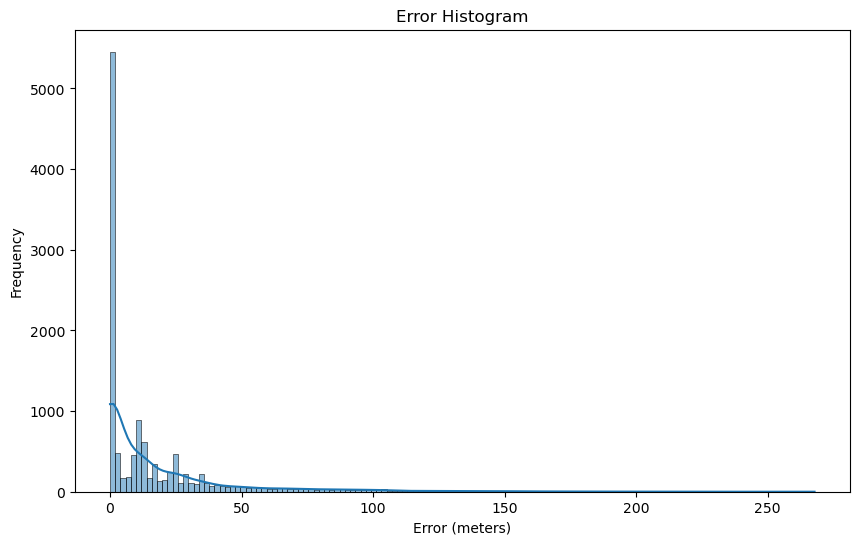

In [32]:
import seaborn as sns

### error histogram plot
plt.figure(figsize=(10, 6))
sns.histplot(errors_in_meters, kde=True)
plt.title('Error Histogram')
plt.xlabel('Error (meters)')
plt.ylabel('Frequency')
plt.show()

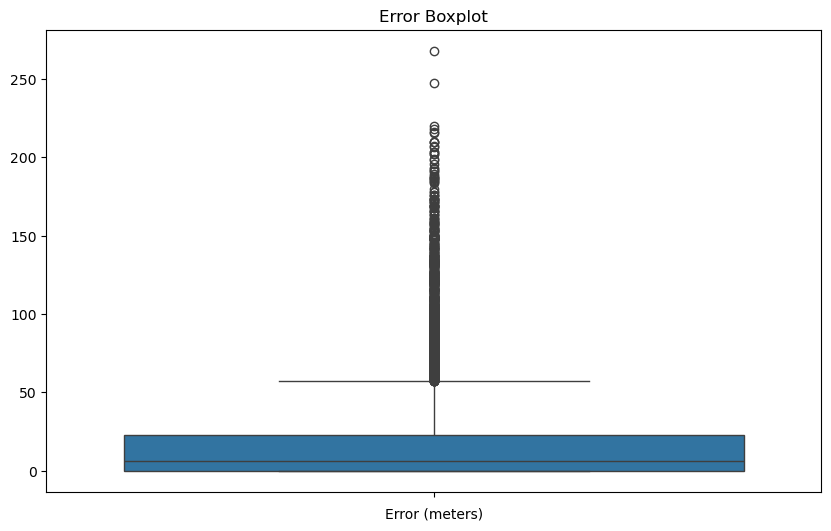

In [33]:
### error boxplot plot
plt.figure(figsize=(10, 6))
sns.boxplot(errors_in_meters)
plt.title('Error Boxplot')
plt.xlabel('Error (meters)')
plt.show()

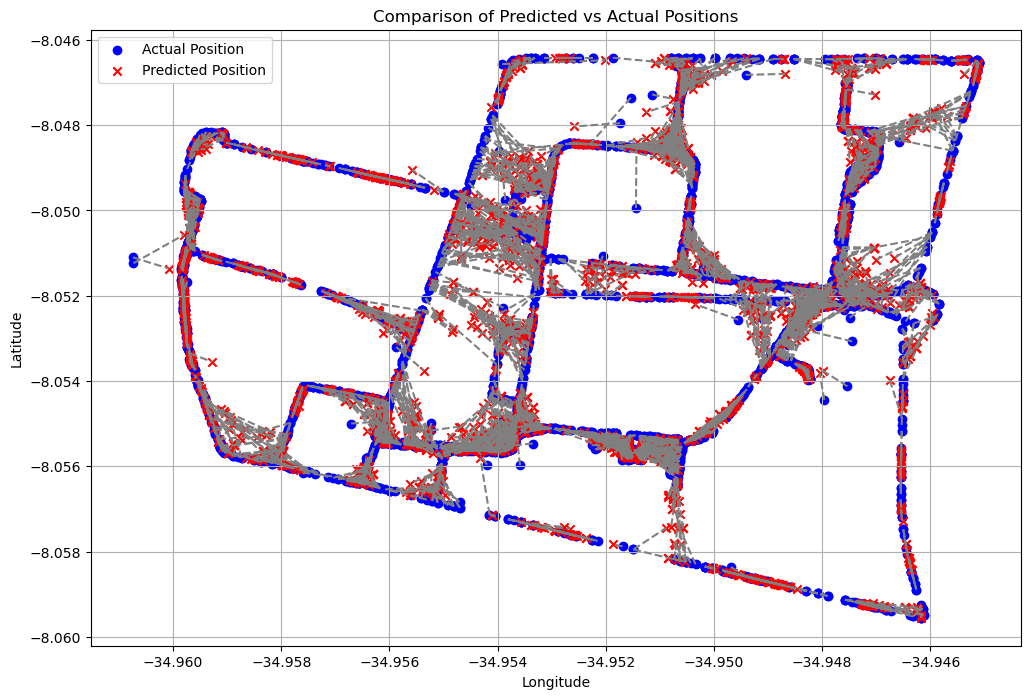

In [34]:
true_lat = y_test['lat_y'].values
true_lon = y_test['lon_y'].values

pred_lat = predicted_location[:, 1]
pred_lon = predicted_location[:, 0]

plt.figure(figsize=(12, 8))
plt.scatter(true_lon, true_lat, color='blue', label='Actual Position')
plt.scatter(pred_lon, pred_lat, color='red', marker='x', label='Predicted Position')

for i in range(len(true_lat)):
    plt.plot([true_lon[i], pred_lon[i]], [true_lat[i], pred_lat[i]], 'gray', linestyle='--')

plt.title('Comparison of Predicted vs Actual Positions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()